### Spring 2025 ECG Analysis 

##### Modification: switched from rapidHRV to Systole for heart rate preprocessing & peak detection

In [30]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from scipy.stats import sem
from copy import copy as copy
import operator as operator

import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from functools import reduce

%pylab inline
figsize(5, 5)

import glob

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_48117/1845472488.py:13: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr # Pearson's correlation
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['copy', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
import pathlib
from ecgdetectors import Detectors
import sys
sampleRate = 100
fs = sampleRate
detectors = Detectors(sampleRate)


In [3]:
mergedDFClean = pd.read_csv("mergedPhysioAndBehav_Jan2025.csv")
# remove Unamed columns
mergedDFClean = mergedDFClean.loc[:, ~mergedDFClean.columns.str.contains('^Unnamed')]
mergedDFClean['PART_trial'] = mergedDFClean['partNum'].astype(str) + '_' + mergedDFClean['session'].astype(str) + '_' + mergedDFClean['trials'].astype(str)
mergedDFClean = mergedDFClean.dropna()

In [4]:
#screamOn: flagging trials where scream is presented; infoOn: flagging trials where information is chosen

mergedDFClean.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'PART_trial'],
      dtype='object')

# separate signal by participant

# Preprocess data & detect r-peaks

### Use ECG Detectors (two average detector) for r-peak detection

In [5]:
###Uses two average detector for r peak detectino

def preprocess(delaydata):
    delayProcessed = pd.DataFrame()

    for participant in np.unique(delaydata['partNum']):
        dataPart = delaydata[delaydata['partNum'] == participant].copy()
        time =dataPart['time'].values
        signal = dataPart.EKG.values 
        r_peaks = detectors.pan_tompkins_detector(signal)
        peaks_mask = np.zeros_like(signal, dtype=bool)
        peaks_mask[r_peaks] = True

        dataPart['pEKG'] = signal #same as raw EKG value, changing the name for consistency purposes
        dataPart['peak'] = peaks_mask
        dataPart['peak_time'] = np.where(peaks_mask, time, np.nan)

        delayProcessed = pd.concat([delayProcessed, dataPart], ignore_index=True)

    return delayProcessed

# extract baseline using the start trial period (first 2 seconds)

In [51]:
def IBI_baseline(mergedDFClean):
    dataBaseline = mergedDFClean#.loc[(mergedDFClean['startTrial'] == 1)]
    dataBaseline0= preprocess(dataBaseline)

    ### create baseline IBI for each trial

    rows = []

    for participant in dataBaseline0['partNum'].unique():
        part_data = dataBaseline0[dataBaseline0['partNum'] == participant]
        for session in dataBaseline0['session'].unique():
            sess_data = part_data[part_data['session'] == session]
            
            for trial in sess_data['trials'].unique():
                trial_data = sess_data[sess_data['trials'] == trial]
                part_trial = trial_data['PART_trial'].iloc[0]
                delay      = trial_data['delay_time'].iloc[0]

                
                peak_idxs = np.where(trial_data['peak'])[0]        
                
                
                if len(peak_idxs) < 2:
                    mean_ibi = np.nan

                else:
                    ibi_samples = np.diff(peak_idxs)
                    mean_ibi = ibi_samples.mean()/ sampleRate

                rows.append({
                    'participant': participant,
                    'session': session,
                    'trial': trial,
                    'delay_time':  delay,
                    'baseline': mean_ibi,
                    'PART_trial': part_trial
                    
                })
            
    #return baseline_IBI
    baseline_IBI = pd.DataFrame(rows)

    
    return baseline_IBI


# Compute IBI intervals from before infochoice presentation till after stimulus presentation time

In [ ]:
def compute_IBI (data,baseline_df):

    """
    Returns a DataFrame with one row per trial, containing:
      - participant, delay_time, PART_trial
      - IBIs: list of normalized IBIs (s)
      - time_norm: list of IBI timestamps relative to window start (s)
      - cue_norm, stim_norm: cue and stim onsets relative to window start (s)
    """
    rows = []

    for trials in data['PART_trial'].unique():
        trial_data = data[data['PART_trial']==trials]
        participant = trial_data['partNum'].iloc[0]
        delay = trial_data['delay_time'].iloc[0]

        #extract time point stimInfo or stimNoInfo is presented
        if 'stimInfoOnset' in trial_data.columns and trial_data['stimInfoOnset'].eq(1).any():
            cueTime = trial_data.loc[trial_data['stimInfoOnset']==1, 'time'].iloc[0]
        elif 'stimNoInfoOnset' in trial_data.columns and trial_data['stimNoInfoOnset'].eq(1).any():
            cueTime = trial_data.loc[trial_data['stimNoInfoOnset']==1, 'time'].iloc[0]
        else:
            cueTime = np.nan

        #extract time point scream or noScream is presented
        if 'screamOnset' in trial_data.columns and trial_data['screamOnset'].eq(1).any():
            stimTime = trial_data.loc[trial_data['screamOnset']==1,'time'].iloc[0]
        elif 'noScreamOnset' in trial_data.columns and trial_data['noScreamOnset'].eq(1).any():
            stimTime = trial_data.loc[trial_data['noScreamOnset']==1,'time'].iloc[0]    
        else:
            stimTime = np.nan

        #define start and end time of where ibi values will be extracted
        pre_window = 2.0 #adding 2 sec before infocue onset
        post_window = 2.0 #adding 2 sec after outcome stimulus presentation
        start = cueTime - pre_window
        end = stimTime + post_window

        
        # restrict to peaks in that window
        peak_times = trial_data.loc[trial_data['peak']==1, 'time'].values
        in_window = peak_times[(peak_times >= start) & (peak_times <= end)]
        if len(in_window) < 2:
            continue
        
        #compute raw and normalized ibis
        ibis      = np.diff(in_window)
        ibi_times = (in_window[:-1] + in_window[1:]) / 2

        # —— normalize time to window start —— 
        t_norm     = (ibi_times - start).tolist()
        cue_norm   = cueTime   - start
        stim_norm  = stimTime  - start

        base       = baseline_df.loc[
                         baseline_df['PART_trial']==trials,'baseline'
                     ].iloc[0]
        ibis_norm  = (ibis - base).tolist()

        
        # get this trial’s delay_time (or whatever column you have)
        delay = trial_data['delay_time'].iloc[0]

        
        # collect one row per IBI
        rows.append({
            'participant': participant,
            'delay_time':  delay,
            'PART_trial':  trials,
            'IBIs':        ibis_norm,
            'time_norm':   t_norm,
            'cue_norm':    cue_norm,
            'stim_norm':   stim_norm
        })
        
    return pd.DataFrame(rows)

        
    

In [70]:
import numpy as np
import pandas as pd

def avg_IBI(trial_df,baseline_df):
    """
    From trial_df (output of compute_IBI), compute:
      1) per‐trial mean IBI between infoOnset and stimOnset
      2) per‐participant x delay mean of those trial means
      3) per‐delay mean across participants.

    Returns
    -------
    part_delay_df : DataFrame with columns
        participant, delay_time, mean_IBI
    delay_df : DataFrame with columns
        delay_time, mean_IBI_across_participants
    """
    # 1) compute per‐trial means
    trial_means = []
    for _, row in trial_df.iterrows():
        ibis  = row['IBIs']
        times = row['time_norm']
        c, s  = row['cue_norm'], row['stim_norm']
        # select only the IBIs whose midpoint lies between cue and stim
        sel   = [ibi for ibi, t in zip(ibis, times) if c <= t <= s]
        if not sel:
            continue

        mean_norm    = np.mean(sel)
        baseline     = baseline_df.loc[
                           baseline_df['PART_trial']==row['PART_trial'],
                           'baseline'
                       ].iloc[0]
        mean_raw     = mean_norm + baseline

        trial_means.append({
            'participant': row['participant'],
            'delay_time':  row['delay_time'],
            'mean_IBI':    mean_raw
        })

    trial_df2 = pd.DataFrame(trial_means)

    # 2) average by participant x delay
    part_delay_df = (
        trial_df2
        .groupby(['participant','delay_time'], as_index=False)
        ['mean_IBI']
        .mean()
    )

    # 3) average across participants, per delay
    delay_df = (
        part_delay_df
        .groupby('delay_time', as_index=False)
        ['mean_IBI']
        .mean()
    )

    return part_delay_df, delay_df


In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_change_dots_with_error(
    baseline1, baseline2, baseline3,
    raw_part1, raw_part2, raw_part3,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
):
    """
    Plot paired baseline vs. raw dots with error bars for each condition,
    one figure per delay.

    Parameters
    ----------
    baselineX : pd.DataFrame with columns ['participant','delay_time','baseline']
        Trial-level baseline IBIs.
    raw_partX : pd.DataFrame with columns ['participant','delay_time','mean_IBI']
        Participant-level raw IBI means (first output of avg_IBI).
    cond_labels : tuple of 3 condition names in the order of dataframes.
    """
    # --- Summarize baseline: trials→participant→delay ---
    def summarize_baseline(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['baseline'].mean()
        stats = part.groupby('delay_time')['baseline'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_mean', 'sem': f'{label}_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_mean', f'{label}_sem']]

    # --- Summarize raw: participant→delay ---
    def summarize_raw_part(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['mean_IBI'].mean()
        stats = part.groupby('delay_time')['mean_IBI'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_raw_mean', 'sem': f'{label}_raw_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_raw_mean', f'{label}_raw_sem']]

    # baseline summaries
    b1 = summarize_baseline(baseline1, cond_labels[0])
    b2 = summarize_baseline(baseline2, cond_labels[1])
    b3 = summarize_baseline(baseline3, cond_labels[2])
    # raw summaries at participant level
    r1 = summarize_raw_part(raw_part1, cond_labels[0])
    r2 = summarize_raw_part(raw_part2, cond_labels[1])
    r3 = summarize_raw_part(raw_part3, cond_labels[2])

    # merge all on delay_time
    merged = b1.merge(b2, on='delay_time').merge(b3, on='delay_time')
    merged = merged.merge(r1, on='delay_time').merge(r2, on='delay_time').merge(r3, on='delay_time')


    # plotting
    x = np.arange(len(cond_labels))
    offset = 0.05
    for _, row in merged.iterrows():
        delay = row['delay_time']
        base_means = [row[f'{c}_mean'] for c in cond_labels]
        base_sems  = [row[f'{c}_sem']  for c in cond_labels]
        raw_means  = [row[f'{c}_raw_mean'] for c in cond_labels]
        raw_sems   = [row[f'{c}_raw_sem']  for c in cond_labels]

        fig, ax = plt.subplots(figsize=(6,4))
        ax.errorbar(x - offset, base_means, yerr=base_sems,
                    fmt='o', color='C0', label='Baseline', capsize=4)
        ax.errorbar(x + offset, raw_means, yerr=raw_sems,
                    fmt='o', color='C1', label='Raw', capsize=4)
        for xi, b, r in zip(x, base_means, raw_means):
            ax.plot([xi - offset, xi + offset], [b, r],
                    color='gray', linestyle='--', linewidth=1)

        ax.set_xticks(x)
        ax.set_xticklabels(cond_labels)
        ax.set_xlabel('Condition')
        ax.set_ylabel('Mean IBI (s)')
        ax.set_title(f'Change Baseline→Anticipation IBI — Delay {delay}s')
        ax.legend()
        ax.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()


# Implement Functions with data
##### 1. prepocess all data to obtain peak information
##### For the following steps, data is categorized into three main parts: information scream, information no scream, no information
##### 2. compute baseline values for each data cateory
##### 3. compute normalized ibi values
##### 4.(1). compute average ibi values by averaging across trials spanning anticipation (delay) time, separated by delay time
##### 4.(2). pick one beat prior to infoCue onset and three beats after the onset, then average across trials, separated by delay time

In [ ]:
#preprocess all data to obtain peak values
processed_all = preprocess(mergedDFClean)


In [9]:
processed_all.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'PART_trial', 'pEKG', 'peak', 'peak_time'],
      dtype='object')

In [93]:
#compute baseline values for stimInfo_scream, stimInfo_noScream, and stimNoinfo
baseline_IBI_stimInfo_scream= IBI_baseline(processed_all.loc[(processed_all['startTrial'] == 1)& (processed_all['screamOn'] == 1) & (processed_all['infoOn'] == 1) ])
baseine_IBI_stimInfo_noScream = IBI_baseline(processed_all.loc[(processed_all['startTrial'] == 1)& (processed_all['screamOn'] == 0) & (processed_all['infoOn'] == 1) ])
baseine_IBI_stimNoInfo = IBI_baseline(processed_all.loc[(processed_all['startTrial'] == 1)& (processed_all['infoOn'] == 0) ])


In [18]:
# extract all data for stimInfo_scream, stimInfo_noScream, and stimNoinfo
stimInfo_scream_df = processed_all[(processed_all['screamOn']==1)&(processed_all['infoOn']==1)] 
stimInfo_noScream_df = processed_all[(processed_all['screamOn']==0) & (processed_all['infoOn']==1)]
stimNoInfo_df = processed_all[(processed_all['infoOn']==0)]

In [53]:
#compute ibi values for all data
stimInfo_scream_ibis = compute_IBI(stimInfo_scream_df,baseline_IBI_stimInfo_scream)
stimInfo_noScream_ibis = compute_IBI(stimInfo_noScream_df,baseine_IBI_stimInfo_noScream)
stimNoInfo_ibis = compute_IBI(stimNoInfo_df,baseine_IBI_stimNoInfo)

In [131]:
stimInfo_scream_ibis[(stimInfo_scream_ibis['participant']==130)&(stimInfo_scream_ibis['delay_time']==40)]['IBIs']

1318    [-0.03000000001746228, -0.15999999999301506, -...
1320    [0.005714285727091428, 0.035714285696823445, 0...
1321    [0.06428571428571428, -0.0057142856921668095, ...
Name: IBIs, dtype: object

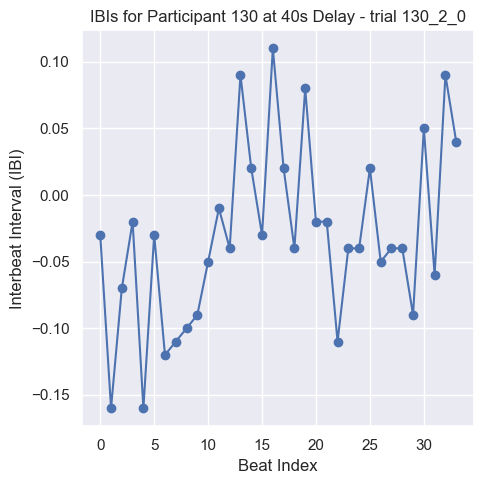

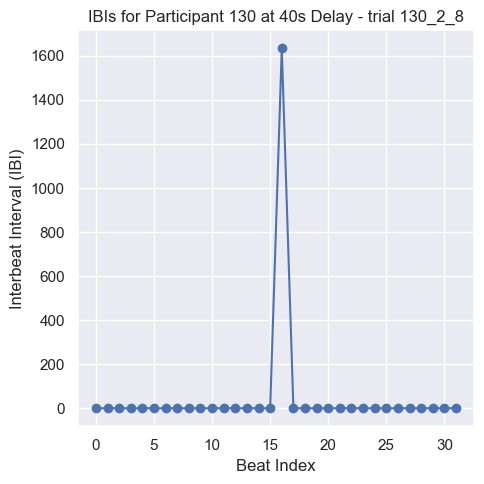

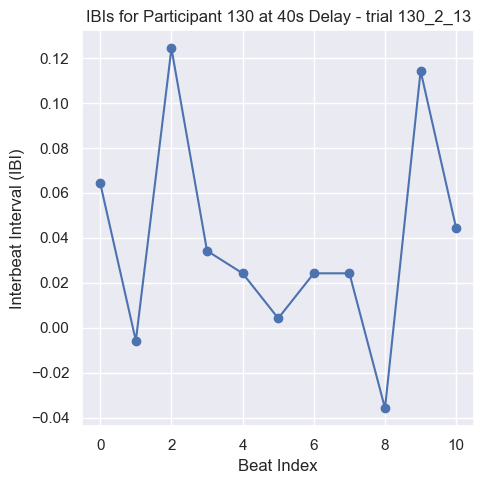

In [137]:
subset = stimInfo_scream_ibis[
    (stimInfo_scream_ibis['participant'] == 130) &
    (stimInfo_scream_ibis['delay_time'] == 40)
]

if not subset.empty:
    for trials in subset['PART_trial'].unique():
        trial_data = subset[subset['PART_trial']==trials]
        ibis = trial_data['IBIs'].iloc[0]
        plt.figure()
        plt.plot(ibis, '-o')
        plt.title(f'IBIs for Participant 130 at 40s Delay - trial {trials}')
        plt.xlabel('Beat Index')
        plt.ylabel('Interbeat Interval (IBI)')
        plt.tight_layout()
        plt.show()
else:
    print("No data found for Participant 130 at delay_time 40.")

In [138]:
processed_all[processed_all['PART_trial']=='130_2_8']

,PART_x,EKG,EDA,startBlock,startTrial,infoChoice,stimInfo,stimNoInfo,scream,noScream,...,delay_time,choice_keys,prob,screamOn,infoOn,filename,PART_trial,pEKG,peak,peak_time
11934582,P130_Aversive,-0.128967,0.521850,0,1,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,-0.128967,False,NaN
11934583,P130_Aversive,0.324707,0.520324,0,1,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,0.324707,False,NaN
11934584,P130_Aversive,1.289000,0.520324,0,1,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,1.289000,False,NaN
11934585,P130_Aversive,1.039250,0.524902,0,1,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,1.039250,False,NaN
11934586,P130_Aversive,-0.160645,0.524902,0,1,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,-0.160645,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11937220,P130_Aversive,0.139038,0.740051,0,0,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,0.139038,False,NaN
11937221,P130_Aversive,0.188660,0.736999,0,0,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,0.188660,False,NaN
11937222,P130_Aversive,0.238159,0.744628,0,0,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,0.238159,False,NaN
11937223,P130_Aversive,0.303528,0.741577,0,0,0,0,0,0,0,...,40.0,l,5.0,1.0,1.0,AV_P130_timeline_Blocks_Extra_randKeyCue_macVe...,130_2_8,0.303528,False,NaN


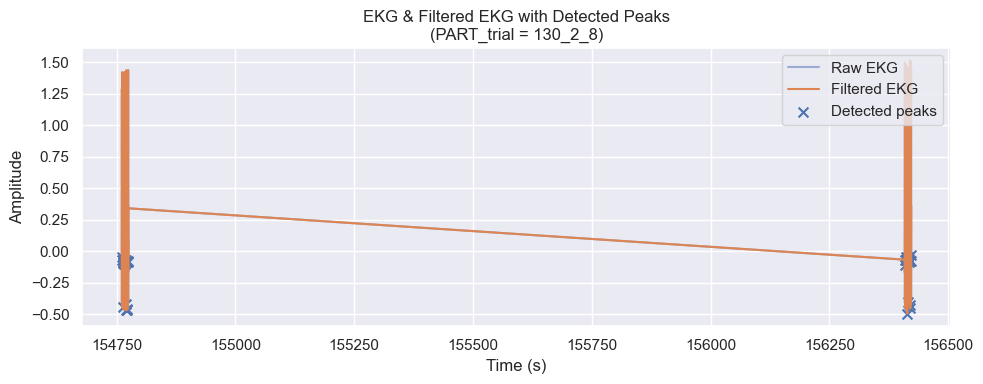

In [139]:
# 1) Select just that trial
trial_df = processed_all[processed_all['PART_trial'] == '130_2_8']

# 2) Grab your time axis — replace 'time' with whatever your time‐stamp column is.
t = trial_df['time']  # e.g. seconds or sample index

# 3) Plot raw EKG and filtered EKG (pEKG), then mark peaks
plt.figure(figsize=(10, 4))
plt.plot(t, trial_df['EKG'],   label='Raw EKG',    alpha=0.5)
plt.plot(t, trial_df['pEKG'],  label='Filtered EKG')

# 4) Overlay detected peaks
peaks = trial_df[trial_df['peak'] == True]
plt.scatter(peaks['time'], peaks['pEKG'],
            marker='x', s=50, label='Detected peaks')

# 5) Labels & legend
plt.title("EKG & Filtered EKG with Detected Peaks\n(PART_trial = 130_2_8)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [134]:
subset

,participant,delay_time,PART_trial,IBIs,time_norm,cue_norm,stim_norm
1318,130,40.0,130_2_0,"[-0.03000000001746228, -0.15999999999301506, -...","[0.39999999999417923, 1.0350000000034925, 1.64...",2.0,22.00
1320,130,40.0,130_2_8,"[0.005714285727091428, 0.035714285696823445, 0...","[0.7150000000256114, 1.400000000023283, 2.0950...",2.0,1654.42
1321,130,40.0,130_2_13,"[0.06428571428571428, -0.0057142856921668095, ...","[0.7749999999941792, 1.4900000000197906, 2.235...",2.0,7.01


In [81]:
part_avg_stimInfo_scream,avg_stimInfo_scream = avg_IBI(stimInfo_scream_ibis,baseline_IBI_stimInfo_scream)
part_avg_stimInfo_noScream,avg_stimInfo_noScream = avg_IBI(stimInfo_noScream_ibis,baseine_IBI_stimInfo_noScream)
part_avg_stimNoInfo, avg_stimNoInfo = avg_IBI(stimNoInfo_ibis,baseine_IBI_stimNoInfo)

In [89]:
part_avg_stimNoInfo

,participant,delay_time,mean_IBI
0,44,2.0,0.707778
1,44,5.0,0.722364
2,44,10.0,0.710860
3,44,20.0,0.700809
4,44,40.0,0.723383
...,...,...,...
201,132,2.0,0.857115
202,132,5.0,0.821965
203,132,10.0,0.811309
204,132,20.0,0.803259


In [72]:
avg_stimInfo_scream

,delay_time,mean_IBI
0,2.0,1.381821
1,5.0,1.137061
2,10.0,1.243234
3,20.0,0.838333
4,40.0,1.364749


In [91]:
avg_stimInfo_scream

,delay_time,mean_IBI
0,2.0,1.381821
1,5.0,1.137061
2,10.0,1.243234
3,20.0,0.838333
4,40.0,1.364749


   delay_time  Info+Scream_mean       std  count  Info+Scream_sem
0         2.0          0.848511  0.122329     44         0.018442
1         5.0          0.851248  0.111028     42         0.017132
2        10.0          0.847540  0.120387     45         0.017946
3        20.0          0.848823  0.118183     45         0.017618
4        40.0          0.830030  0.117146     37         0.019259
   delay_time  Info+NoScream_mean       std  count  Info+NoScream_sem
0         2.0            0.847331  0.168848     44           0.025455
1         5.0            0.846116  0.128864     44           0.019427
2        10.0            0.832871  0.109850     44           0.016561
3        20.0            0.834152  0.117058     44           0.017647
4        40.0            0.817477  0.099203     38           0.016093
   delay_time  NoInfo_mean       std  count  NoInfo_sem
0         2.0     0.842476  0.106368     43    0.016221
1         5.0     0.830431  0.112165     43    0.017105
2        10.0   

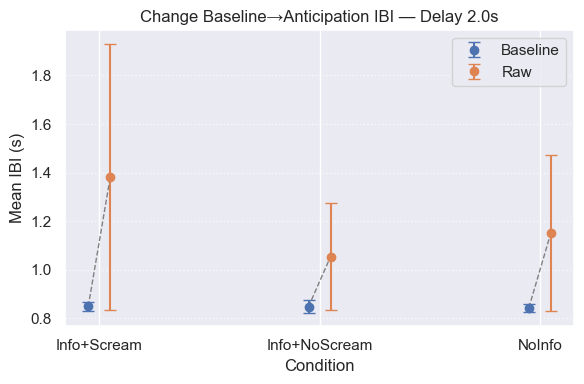

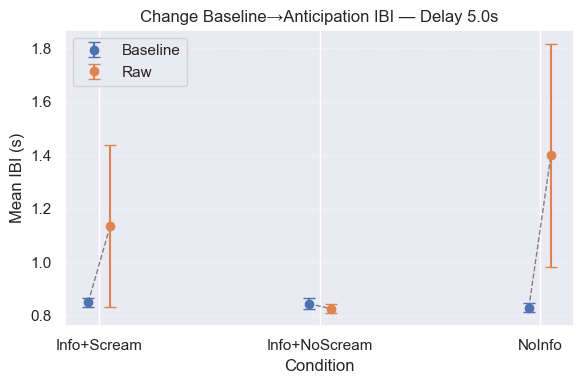

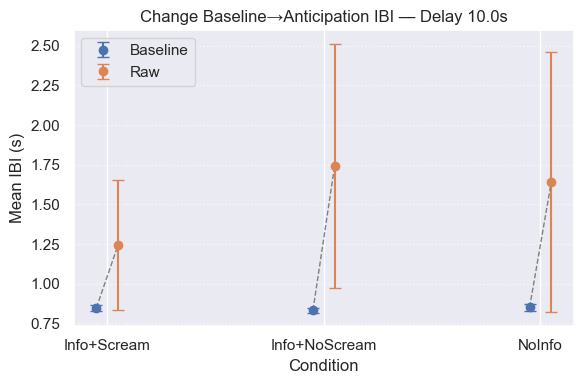

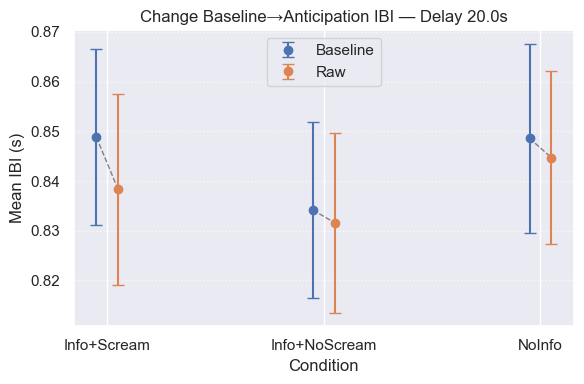

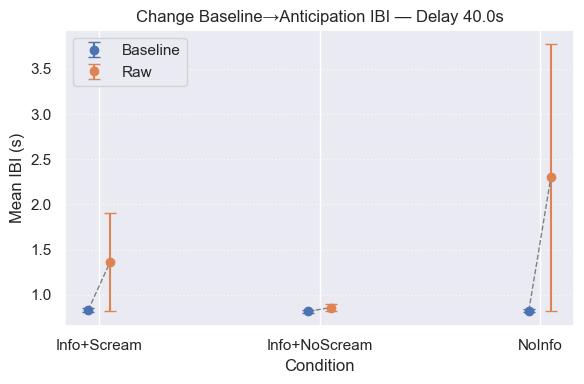

In [112]:
plot_change_dots_with_error(
    baseline_IBI_stimInfo_scream,
    baseine_IBI_stimInfo_noScream,
    baseine_IBI_stimNoInfo,
    part_avg_stimInfo_scream,
    part_avg_stimInfo_noScream,
    part_avg_stimNoInfo,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
)

In [125]:
def plot_change_dots_with_error(
    baseline1, baseline2, baseline3,
    raw_part1, raw_part2, raw_part3,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
):
    """
    Plot paired baseline vs. raw dots with error bars for each condition,
    one figure per delay.

    Parameters
    ----------
    baselineX : pd.DataFrame with columns ['participant','delay_time','baseline']
        Trial-level baseline IBIs.
    raw_partX : pd.DataFrame with columns ['participant','delay_time','mean_IBI']
        Participant-level raw IBI means (first output of avg_IBI).
    cond_labels : tuple of 3 condition names in the order of dataframes.
    """
    # --- Summarize baseline: trials→participant→delay ---
    def summarize_baseline(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['baseline'].mean()
        stats = part.groupby('delay_time')['baseline'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_mean', 'sem': f'{label}_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_mean', f'{label}_sem']]

    # --- Summarize raw: participant→delay ---
    def summarize_raw_part(df, label):
        part = df.groupby(['participant','delay_time'], as_index=False)['mean_IBI'].mean()
        stats = part.groupby('delay_time')['mean_IBI'].agg(['mean','std','count']).reset_index()
        stats['sem'] = stats.apply(
            lambda r: (r['std'] / np.sqrt(r['count'])) if r['count'] >= 2 else 0.0,
            axis=1
        )
        stats = stats.rename(columns={'mean': f'{label}_raw_mean', 'sem': f'{label}_raw_sem'})
        print(stats)
        return stats[['delay_time', f'{label}_raw_mean', f'{label}_raw_sem']]

    # baseline summaries
    b1 = summarize_baseline(baseline1, cond_labels[0])
    b2 = summarize_baseline(baseline2, cond_labels[1])
    b3 = summarize_baseline(baseline3, cond_labels[2])
    # raw summaries at participant level
    r1 = summarize_raw_part(raw_part1, cond_labels[0])
    r2 = summarize_raw_part(raw_part2, cond_labels[1])
    r3 = summarize_raw_part(raw_part3, cond_labels[2])

    # merge all on delay_time
    merged = b1.merge(b2, on='delay_time').merge(b3, on='delay_time')
    merged = merged.merge(r1, on='delay_time').merge(r2, on='delay_time').merge(r3, on='delay_time')

    # plotting
    x = np.arange(len(cond_labels))
    offset = 0.15
    widths = 0.25

    for _, row in merged.iterrows():
        delay = row['delay_time']

        # collect the raw arrays for this delay
        base_data = [
            baseline1.loc[baseline1['delay_time']==delay, 'baseline'],
            baseline2.loc[baseline2['delay_time']==delay, 'baseline'],
            baseline3.loc[baseline3['delay_time']==delay, 'baseline'],
        ]
        raw_data = [
            raw_part1.loc[raw_part1['delay_time']==delay, 'mean_IBI'],
            raw_part2.loc[raw_part2['delay_time']==delay, 'mean_IBI'],
            raw_part3.loc[raw_part3['delay_time']==delay, 'mean_IBI'],
        ]

        fig, ax = plt.subplots(figsize=(6,4))

        # boxplots for baseline (blue) & raw (orange)
        bp1 = ax.boxplot(
            base_data,
            positions = x - offset,
            widths    = widths,
            patch_artist=True,
            boxprops  = dict(facecolor='C0', alpha=0.3),
            medianprops=dict(color='C0'),
            whiskerprops=dict(color='C0'),
            capprops   =dict(color='C0'),
            flierprops =dict(markeredgecolor='C0')
        )
        bp2 = ax.boxplot(
            raw_data,
            positions = x + offset,
            widths    = widths,
            patch_artist=True,
            boxprops  = dict(facecolor='C1', alpha=0.3),
            medianprops=dict(color='C1'),
            whiskerprops=dict(color='C1'),
            capprops   =dict(color='C1'),
            flierprops =dict(markeredgecolor='C1')
        )

        # overlay the means as dots if you like
        base_means = [row[f'{c}_mean'] for c in cond_labels]
        raw_means  = [row[f'{c}_raw_mean'] for c in cond_labels]
        ax.scatter(x - offset, base_means, color='C0', s=50, zorder=3)
        ax.scatter(x + offset, raw_means,  color='C1', s=50, zorder=3)

        ax.set_xticks(x)
        ax.set_xticklabels(cond_labels)
        ax.set_xlabel('Condition')
        ax.set_ylabel('Mean IBI (s)')
        ax.set_title(f'Change Baseline→Raw IBI — Delay {delay}s')

        # legend hack
        ax.plot([], [], color='C0', label='Baseline')
        ax.plot([], [], color='C1', label='Raw')
        ax.legend()

        ax.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()


   delay_time  Info+Scream_mean       std  count  Info+Scream_sem
0         2.0          0.848511  0.122329     44         0.018442
1         5.0          0.851248  0.111028     42         0.017132
2        10.0          0.847540  0.120387     45         0.017946
3        20.0          0.848823  0.118183     45         0.017618
4        40.0          0.830030  0.117146     37         0.019259
   delay_time  Info+NoScream_mean       std  count  Info+NoScream_sem
0         2.0            0.847331  0.168848     44           0.025455
1         5.0            0.846116  0.128864     44           0.019427
2        10.0            0.832871  0.109850     44           0.016561
3        20.0            0.834152  0.117058     44           0.017647
4        40.0            0.817477  0.099203     38           0.016093
   delay_time  NoInfo_mean       std  count  NoInfo_sem
0         2.0     0.842476  0.106368     43    0.016221
1         5.0     0.830431  0.112165     43    0.017105
2        10.0   

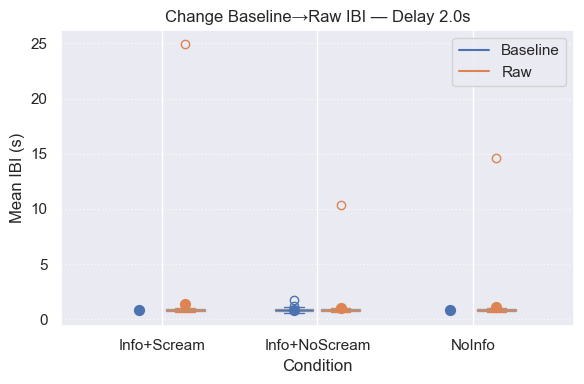

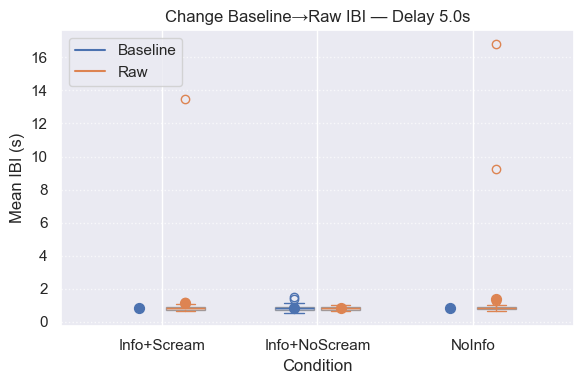

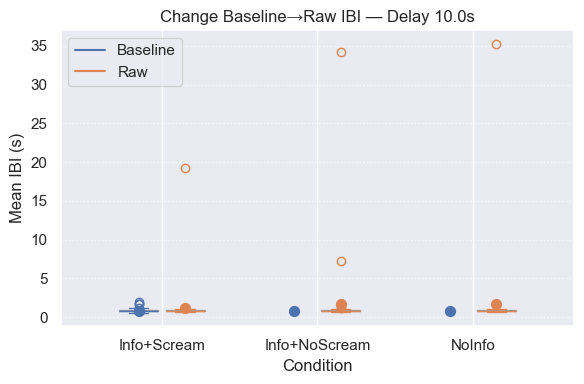

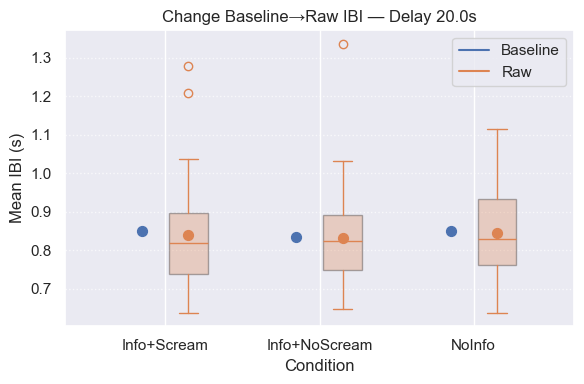

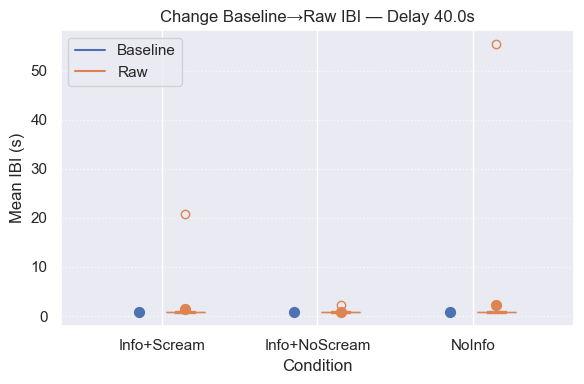

In [126]:
plot_change_dots_with_error(
    baseline_IBI_stimInfo_scream,
    baseine_IBI_stimInfo_noScream,
    baseine_IBI_stimNoInfo,
    part_avg_stimInfo_scream,
    part_avg_stimInfo_noScream,
    part_avg_stimNoInfo,
    cond_labels=('Info+Scream','Info+NoScream','NoInfo')
)

# Check Data

Baseline trial-level for 20's delay:
count    296.000000
mean       0.842729
std        0.150745
min        0.582500
25%        0.736667
50%        0.820000
75%        0.930000
max        1.850000
Name: baseline, dtype: float64
    participant  session  trial  delay_time  baseline PART_trial
15           44        3     13        20.0     0.740    44_3_13
16           45        0      0        20.0     0.720     45_0_0
18           45        0      3        20.0     0.750     45_0_3
26           45        0     18        20.0     0.920    45_0_18
32           45        1      9        20.0     0.920     45_1_9
37           45        1     17        20.0     0.830    45_1_17
39           45        2      1        20.0     0.960     45_2_1
42           45        2      6        20.0     0.910     45_2_6
43           45        2      7        20.0     0.875     45_2_7
58           45        3     13        20.0     0.805    45_3_13

Participant-level mean baselines at 20's:
       partici

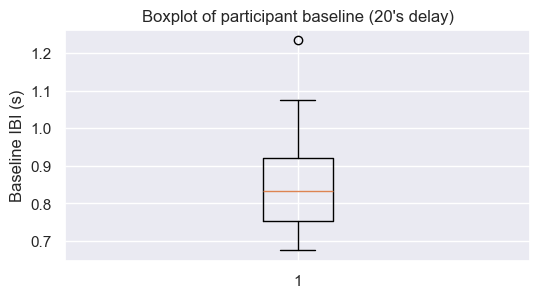


Participant-level raw means at 20's:
       participant   mean_IBI
count    45.000000  45.000000
mean     92.222222   0.838333
std      28.089863   0.128470
min      44.000000   0.637293
25%      67.000000   0.736951
50%      98.000000   0.818930
75%     115.000000   0.896118
max     132.000000   1.279248
    participant  mean_IBI
0            44  0.733571
1            45  0.879456
2            48  0.747184
3            49  0.920985
4            50  0.865368
5            53  0.732773
6            58  0.721656
7            59  0.823467
8            60  0.708350
9            61  0.645662
10           65  0.987028
11           67  0.902385
12           68  0.735372
13           69  1.036292
14           71  0.730434
15           75  0.789231
16           82  0.916364
17           91  1.279248
18           92  0.736951
19           93  0.740567
20           96  0.822775
21           97  0.906292
22           98  0.794438
23           99  0.851443
24          100  1.209196
25          101 

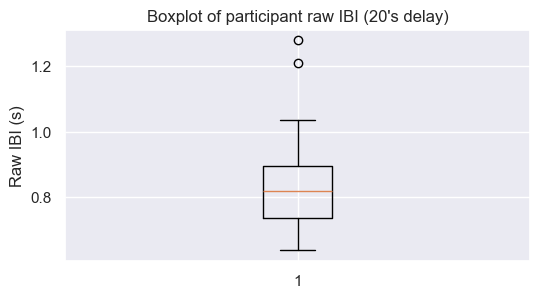

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Look at the raw trial‑level baselines for delay 20
d20_baseline_trials = baseline_IBI_stimInfo_scream[baseline_IBI_stimInfo_scream['delay_time']==20]
print("Baseline trial-level for 20's delay:")
print(d20_baseline_trials['baseline'].describe())
print(d20_baseline_trials['.head(10)'])

# 2) Look at the participant‑level baselines before you average them
part20 = d20_baseline_trials.groupby('participant')['baseline'].mean().reset_index()
print("\nParticipant-level mean baselines at 20's:")
print(part20.describe())
print(part20)

# 3) Plot the distribution to spot outliers
plt.figure(figsize=(6,3))
plt.boxplot(part20['baseline'].dropna())
plt.title("Boxplot of participant baseline (20's delay)")
plt.ylabel("Baseline IBI (s)")
plt.show()

# 4) Do the same for your raw IBI means
d20_raw_trials = part_avg_stimInfo_scream[part_avg_stimInfo_scream['delay_time']==20]
# compute per‐participant raw means if needed:
part20_raw = d20_raw_trials.groupby('participant')['mean_IBI'].mean().reset_index()
print("\nParticipant-level raw means at 20's:")
print(part20_raw.describe())
print(part20_raw)

plt.figure(figsize=(6,3))
plt.boxplot(part20_raw['mean_IBI'].dropna())
plt.title("Boxplot of participant raw IBI (20's delay)")
plt.ylabel("Raw IBI (s)")
plt.show()


In [117]:
d20_raw_trials

,delay_time,mean_IBI
3,20.0,0.838333


In [120]:
part_avg_stimInfo_scream

,participant,delay_time,mean_IBI
0,44,2.0,0.712381
1,44,5.0,0.705714
2,44,10.0,0.715948
3,44,20.0,0.733571
4,45,2.0,0.858095
...,...,...,...
208,131,20.0,0.778462
209,132,5.0,0.772857
210,132,10.0,0.817817
211,132,20.0,0.831089


Baseline trial-level for 40's delay:
count    102.000000
mean       0.843211
std        0.132830
min        0.602500
25%        0.745000
50%        0.832500
75%        0.950000
max        1.220000
Name: baseline, dtype: float64
Empty DataFrame
Columns: [participant, session, trial, delay_time, baseline, PART_trial]
Index: []

Participant-level mean baselines at 40's:
       participant   baseline
count    38.000000  37.000000
mean     92.184211   0.830030
std      28.767338   0.117146
min      45.000000   0.620000
25%      65.500000   0.748333
50%      99.000000   0.815000
75%     117.250000   0.912000
max     132.000000   1.108333
    participant  baseline
0            45  0.815000
1            48  0.770000
2            49  0.916667
3            50  0.997500
4            53  0.712500
5            58  0.681667
6            59  0.882500
7            60  0.620000
8            61  0.657292
9            65  0.980000
10           67  0.985000
11           68  0.753333
12           69  1.067

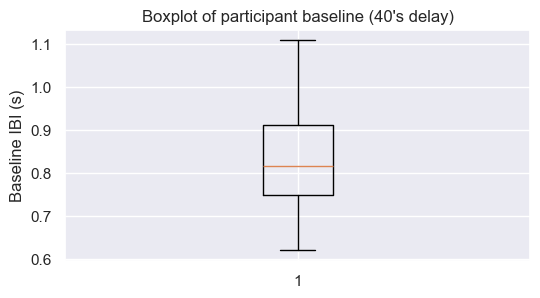

     participant  delay_time   mean_IBI
205          130        40.0  20.872335

Participant-level raw means at 40's:
       participant   mean_IBI
count    37.000000  37.000000
mean     91.675676   1.364749
std      28.990472   3.297340
min      45.000000   0.665676
25%      65.000000   0.744430
50%      98.000000   0.825171
75%     118.000000   0.887556
max     132.000000  20.872335
    participant   mean_IBI
0            45   0.825171
1            48   0.768807
2            49   0.928876
3            50   0.844792
4            53   0.737003
5            58   0.721766
6            59   0.829279
7            60   0.681017
8            61   0.665676
9            65   0.982000
10           67   0.897741
11           68   0.736545
12           69   0.996227
13           71   0.744430
14           75   0.842956
15           91   0.907165
16           93   0.767121
17           96   0.669831
18           98   0.788627
19          100   0.912778
20          101   0.988895
21          105   

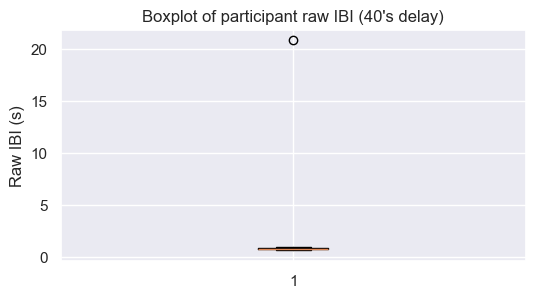

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Look at the raw trial‑level baselines for delay 40
d40_baseline_trials = baseline_IBI_stimInfo_scream[baseline_IBI_stimInfo_scream['delay_time']==40]
print("Baseline trial-level for 40's delay:")
print(d40_baseline_trials['baseline'].describe())
print(d40_baseline_trials[d40_baseline_trials['baseline']>2])

# 2) Look at the participant‑level baselines before you average them
part40 = d40_baseline_trials.groupby('participant')['baseline'].mean().reset_index()
print("\nParticipant-level mean baselines at 40's:")
print(part40.describe())
print(part40)

# 3) Plot the distribution to spot outliers
plt.figure(figsize=(6,3))
plt.boxplot(part40['baseline'].dropna())
plt.title("Boxplot of participant baseline (40's delay)")
plt.ylabel("Baseline IBI (s)")
plt.show()

# 4) Do the same for your raw IBI means
d40_raw_trials = part_avg_stimInfo_scream[part_avg_stimInfo_scream['delay_time']==40]

# compute per‐participant raw means if needed:
part40_raw = d40_raw_trials.groupby('participant')['mean_IBI'].mean().reset_index()
print(d40_raw_trials[d40_raw_trials['mean_IBI']>2])

print("\nParticipant-level raw means at 40's:")
print(part40_raw.describe())
print(part40_raw)

plt.figure(figsize=(6,3))
plt.boxplot(part40_raw['mean_IBI'].dropna())
plt.title("Boxplot of participant raw IBI (40's delay)")
plt.ylabel("Raw IBI (s)")
plt.show()
